In [2]:
# !pip install chess

In [1]:
import chess
import chess.svg
import chess.pgn

import random
import math
from time import sleep
import numpy as np

import sys
sys.setrecursionlimit(10**9)

from IPython.display import clear_output




In [2]:
# Define piece values
# piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0}
piece_values = {chess.PAWN: 100, chess.KNIGHT: 320, chess.BISHOP: 330, chess.ROOK: 500, chess.QUEEN: 900, chess.KING: 20000}

PAWN_TABLE = [
    0, 0, 0, 0, 0, 0, 0, 0,
    5, 10, 10, -20, -20, 10, 10, 5,
    5, -5, -10, 0, 0, -10, -5, 5,
    0, 0, 0, 20, 20, 0, 0, 0,
    5, 5, 10, 25, 25, 10, 5, 5,
    10, 10, 20, 30, 30, 20, 10, 10,
    50, 50, 50, 50, 50, 50, 50, 50,
    0, 0, 0, 0, 0, 0, 0, 0
]

KNIGHTS_TABLE = [
    -50, -40, -30, -30, -30, -30, -40, -50,
    -40, -20, 0, 5, 5, 0, -20, -40,
    -30, 5, 10, 15, 15, 10, 5, -30,
    -30, 0, 15, 20, 20, 15, 0, -30,
    -30, 5, 15, 20, 20, 15, 5, -30,
    -30, 0, 10, 15, 15, 10, 0, -30,
    -40, -20, 0, 0, 0, 0, -20, -40,
    -50, -40, -30, -30, -30, -30, -40, -50,
]


BISHOPS_TABLE = [
    -20, -10, -10, -10, -10, -10, -10, -20,
    -10, 5, 0, 0, 0, 0, 5, -10,
    -10, 10, 10, 10, 10, 10, 10, -10,
    -10, 0, 10, 10, 10, 10, 0, -10,
    -10, 5, 5, 10, 10, 5, 5, -10,
    -10, 0, 5, 10, 10, 5, 0, -10,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -20, -10, -10, -10, -10, -10, -10, -20
]


ROOKS_TABLE = [
    0, 0, 0, 5, 5, 0, 0, 0,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    -5, 0, 0, 0, 0, 0, 0, -5,
    5, 10, 10, 10, 10, 10, 10, 5,
    0, 0, 0, 0, 0, 0, 0, 0
]

QUEENS_TABLE = [
    -20, -10, -10, -5, -5, -10, -10, -20,
    -10, 0, 0, 0, 0, 0, 0, -10,
    -10, 0, 5, 5, 5, 5, 0, -10,
    -5, 0, 5, 5, 5, 5, 0, -5,
    0, 0, 5, 5, 5, 5, 0, -5,
    -10, 5, 5, 5, 5, 5, 0, -10,
    -10, 0, 5, 0, 0, 0, 0, -10,
    -20, -10, -10, -5, -5, -10, -10, -20
]


KINGS_TABLE_OPENING = [
    20, 30, 10,  0,  0, 10, 30, 20,
    20, 20,  0,  0,  0,  0, 20, 20,
    -10,-20,-20,-20,-20,-20,-20,-10,
    -20,-30,-30,-40,-40,-30,-30,-20,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30,
    -30,-40,-40,-50,-50,-40,-40,-30
]


KINGS_TABLE_ENDGAME = [
    -50,-40,-30,-20,-20,-30,-40,-50,
    -30,-20,-10,  0,  0,-10,-20,-30,
    -30,-10, 20, 30, 30, 20,-10,-30,
    -30,-10, 30, 40, 40, 30,-10,-30,
    -30,-10, 30, 40, 40, 30,-10,-30,
    -30,-10, 20, 30, 30, 20,-10,-30,
    -30,-30,  0,  0,  0,  0,-30,-30,
    -50,-30,-30,-30,-30,-30,-30,-50
]


In [3]:
def get_eval_score(board):
    # Calculate material balance
    material_balance = sum(len(board.pieces(piece_type, chess.WHITE)) * value for piece_type, value in piece_values.items()) - \
                       sum(len(board.pieces(piece_type, chess.BLACK)) * value for piece_type, value in piece_values.items())
    return material_balance

def get_count_pieces_on_board(board):
    # Initialize a counter
    piece_count = 0

    # Iterate through all squares on the board
    for square in chess.SQUARES:
        # Check if there is a piece on the square
        if board.piece_at(square):
            # If yes, increment the counter
            piece_count += 1

    return piece_count


def get_count_total_material(board):
    return sum(len(board.pieces(piece_type, chess.WHITE)) * value for piece_type, value in piece_values.items()) + \
                       sum(len(board.pieces(piece_type, chess.BLACK)) * value for piece_type, value in piece_values.items())

In [4]:



class ChessBot:
    def __init__(self, temperature=1.0, is_white=True):
        self.temperature = temperature
        self.initial_temperature = temperature
        self.is_white = is_white

    def evaluate_board(self, board):
        # Simple evaluation function - you might want to develop a more sophisticated one
        if board.is_checkmate():
            return float("-inf") if board.turn == chess.WHITE else float("inf")
        if board.is_stalemate():
            return 0
        # Example: Just count the material balance for simplicity
        return get_eval_score(board)

    def minimax(self, board, depth, alpha, beta, maximizing_player):
        if depth == 0 or board.is_game_over():
            return self.evaluate_board(board)

        if maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, not maximizing_player)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, alpha, beta, not maximizing_player)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def get_best_move(self, board):
        best_value = float('-inf') if self.is_white else float("inf")
        alpha = float('-inf')
        beta = float('inf')
        # depth = 2 + (78 - get_count_total_material(board)) // 9  # 2078 = sum of initial balance of both players
        depth = 3
        
        moves = {}
        for move in board.legal_moves:
            board.push(move)
            move_value = self.minimax(board, depth, alpha, beta, not self.is_white)
            board.pop()

            # if (self.is_white and move_value > best_value) or (not self.is_white and move_value < best_value):
            #     best_value = move_value
            #     best_moves = [move]
            # elif move_value == best_value:
            #     best_moves.append(move)

            moves[move] = move_value
            best_value = max(best_value, move_value) if self.is_white else min(best_value, move_value)

        filtered_moves = {key: value for key, value in moves.items() if abs(value-best_value) <= self.temperature}
        moves = np.array(list(filtered_moves.keys()))
        move_scores = np.array(list(filtered_moves.values()))

        exp_scores = np.exp(-np.abs(move_scores - best_value))
        probabilities = exp_scores / np.sum(exp_scores)

        # Choose a move based on the calculated probabilities
        chosen_move = np.random.choice(moves, p=probabilities)

        # Adjust temperature for the next move
        self.temperature = max(0, self.temperature - 0.1)

        return chosen_move


  # TODO: Actually make it be able to mate, it misses a mate in 1 still
  # TODO: Queen still gets randomly taken
  # TODO: Make loosing castling possibility be a bad thing
  # TODO: Slows down too much too quickly

In [29]:
class ChessBot2:
    def __init__(self, depth=2):
        self.depth = depth

    def get_best_move(self, board):
        best_move = self.select_move(board, depth=self.depth, is_maximizing=board.turn == chess.WHITE)
        return best_move

    def make_move(self, board):
        best_move = self.get_best_move(board)
        board.push(best_move)

    def select_move(self, board, depth=2, alpha=float('-inf'), beta=float('inf'), is_maximizing=True):
        if is_maximizing:
            max_eval = float('-inf')
            best_move = None
            for move in board.legal_moves:
                board.push(move)
                eval = self.__alpha_beta_minimax_helper(board, depth - 1, alpha, beta, False)
                board.pop()
                if eval > max_eval:
                    max_eval = eval
                    best_move = move
                alpha = max(alpha, eval)
                if beta <= alpha:  # TODO: should this be the condition for both case ?
                    break
            return best_move
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.__alpha_beta_minimax_helper(board, depth - 1, alpha, beta, True)
                board.pop()
                if eval < min_eval:
                    min_eval = eval
                    best_move = move
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return best_move

    def __alpha_beta_minimax_helper(self, board, depth=3, alpha=float('-inf'), beta=float('inf'), is_maximizing=True):
        if depth == 0 or board.is_game_over():
            return self.evaluate_board(board, depth)

        if is_maximizing:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.__alpha_beta_minimax_helper(board, depth - 1, alpha, beta, False)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:  # TODO: should this be the condition for both case ?
                    break
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.__alpha_beta_minimax_helper(board, depth - 1, alpha, beta, True)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval

    def evaluate_board(self, board, depth):
        """
        Given a particular board, evaluates it and gives it a score.
        A higher score indicates it is better for white.
        A lower score indicates it is better for black.

        Args:
            board (chess.Board): A chess board.

        Returns:
            int: A score indicating the state of the board (higher is good for white, lower is good for black)
        """    
        global piece_values

        if board.is_checkmate():
            if board.turn == chess.WHITE:
                return -1e6 - depth
            else:
                return 1e6 + depth
        if board.is_stalemate():
            return 0

        # Material values
        piece_square_tables = {
            chess.PAWN: PAWN_TABLE,
            chess.KNIGHT: KNIGHTS_TABLE,
            chess.BISHOP: BISHOPS_TABLE,
            chess.ROOK: ROOKS_TABLE,
            chess.QUEEN: QUEENS_TABLE,
            chess.KING: KINGS_TABLE_OPENING if not self.is_endgame(board) else KINGS_TABLE_ENDGAME,
        }

        boardvalue = 0
        for piece_type in piece_values.keys():
            for color in [chess.WHITE, chess.BLACK]:
                sign = 1 if color == chess.WHITE else -1
                pieces = board.pieces(piece_type, color)
                material_value = piece_values[piece_type] * len(pieces)
                positional_value = sum(piece_square_tables[piece_type][i] for i in pieces)
                if color == chess.WHITE:
                    positional_value = sum(piece_square_tables[piece_type][i] for i in pieces)
                else:  # Correctly mirror and apply positional values for black
                    positional_value = sum(piece_square_tables[piece_type][chess.square_mirror(i)] for i in pieces)
                boardvalue += sign * (material_value + positional_value)

        return boardvalue
    
    def is_endgame(self, board):
        return chess.QUEEN not in board.piece_map().values() or len(board.piece_map()) < 12
    
    # TODO: Silly mate by repeition, shouldn't have happened, also didn't detect => just hardcode accepting stalemate or avoiding based on current eval.
    # TODO: Endgames aren't working properly => Increase depth
    # TODO: Black plays horribly
    # TODO: White decided to hang a bishop for now reason in a winning position

## Play against self

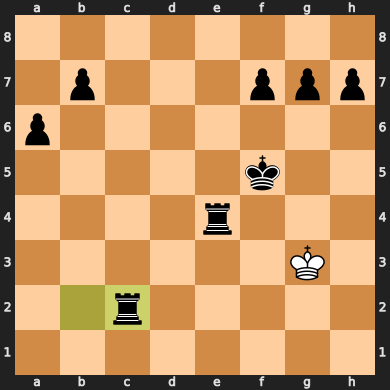

'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples are taken
'a' cannot be empty unless no samples ar

In [31]:
# Example usage
# whiteBot = ChessBot(temperature=0)
# blackBot = ChessBot(temperature=0, is_white=False)

whiteBot = ChessBot()
blackBot = ChessBot2(depth=4)
# whiteBot = ChessBot2(depth=4)
# blackBot = ChessBot()

board = chess.Board()
# Example game loop
while not board.is_game_over():
    try:
        # white
        move = whiteBot.get_best_move(board)
        board.push(move)

        clear_output(wait=True)
        display(board)
        # sleep(1)

        # black
        move = blackBot.get_best_move(board)
        board.push(move)

        clear_output(wait=True)
        display(board)
        # sleep(1)

    except Exception as e:
        print(e)
    except KeyboardInterrupt:
        print("Game ended by lack of patience")
        break

game = chess.pgn.Game()
game.headers["Event"] = "Self Game"
game.headers["White"] = "White"
game.headers["Black"] = "Black"

# Use the board's move stack to set up the game's moves
game.setup(board)
game = game.from_board(board)

# Export the game to PGN format
exporter = chess.pgn.StringExporter(headers=True, variations=True, comments=True)
pgn_string = game.accept(exporter)

# Print the game in PGN format
print(pgn_string)

## Play against human (w. debuging)

Current board:


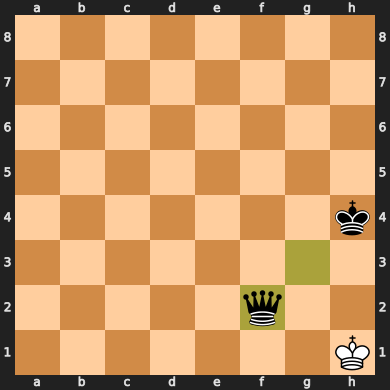

FEN string: 8/8/8/8/7k/8/5q2/7K w - - 38 84
Game over: 1/2-1/2
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "1/2-1/2"]

1. d4 Nc6 2. Nf3 Nb4 3. c4 c5 4. e3 cxd4 5. Nxd4 Qb6 6. Nc3 Qf6 7. Bd3 Nxd3+ 8.
Qxd3 g6 9. O-O b6 10. Ndb5 Qe5 11. Qd4 Qxd4 12. exd4 Ba6 13. Nc7+ Kd8 14. Nxa8
Bxc4 15. Re1 Bg7 16. b3 Bxd4 17. bxc4 Bxc3 18. Bf4 d6 19. Be3 b5 20. cxb5 f6
21. Bxa7 Bxa1 22. Rxa1 Kd7 23. Rb1 Ke6 24. b6 Kf5 25. b7 Nh6 26. b8=Q Rxb8 27.
Rxb8 Ng4 28. h3 Nh6 29. Nc7 Ke4 30. Rb3 Ng8 31. f3+ Ke5 32. g4 h5 33. Re3+ Kf4
34. Kf2 hxg4 35. fxg4 Kg5 36. Ne6+ Kh4 37. Bb6 Nh6 38. Ba5 g5 39. Be1 Nxg4+ 40.
hxg4 Kxg4 41. Nd4 e5 42. Re4+ Kh5 43. Nf3 g4 44. Nh2 f5 45. Ra4 f4 46. Ra8 g3+
47. Kf3 gxh2 48. Rh8+ Kg6 49. Rxh2 Kg7 50. Bb4 d5 51. Rd2 d4 52. Ke4 Kf6 53.
Bd6 Kg7 54. Kxe5 Kg8 55. Kf6 f3 56. Rb2 Kh7 57. Rb8 f2 58. Rb1 d3 59. Rf1 d2
60. Rxf2 d1=Q 61. Rh2+ Kg8 62. Kg6 Qxd6+ 63. Kh5 Qxh2+ 64. Kg5 Qxa2 65. Kg6
Qf7+ 66. Kh6 Qg7+ 67. Kh5 Kh8 68. Kh4 Qg8 69. Kh5 Qg7 7

In [ ]:
import ipywidgets as widgets

# Assuming ChessBot2 is defined elsewhere and initialized as blackBot
# blackBot = ChessBot2(is_white=False)
board = chess.Board()
bot2 = ChessBot2()

# Function to handle the human move submission
def on_move_submitted(b):
    global board  # Refer to the global board variable

    # Process the human move
    move_str = move_input.value
    move = chess.Move.from_uci(move_str)
    if move in board.legal_moves:
        board.push(move)
        update_display()

# Function to handle the bot move button click
def on_bot_move_clicked(b):
    global board  # Refer to the global board variable

    if not board.is_game_over():
        bot_move = bot2.get_best_move(board)
        board.push(bot_move)
        update_display()

# Function to handle the FEN string submission
def on_fen_submitted(b):
    global board  # Refer to the global board variable

    # Process the FEN string
    fen_str = fen_input.value
    try:
        board.set_fen(fen_str)
        update_display()
    except:
        print("Invalid FEN string. Please try again.")

# Function to update the display of the board and input widgets
def update_display():
    clear_output(wait=True)
    print("Current board:")
    display(board)
    print("FEN string:", board.fen())
    if board.is_game_over():
        print("Game over:", board.result())

        game = chess.pgn.Game()
        game.headers["Event"] = "Self Game"
        game.headers["White"] = "White"
        game.headers["Black"] = "Black"

        # Use the board's move stack to set up the game's moves
        game.setup(board)
        game = game.from_board(board)

        # Export the game to PGN format
        exporter = chess.pgn.StringExporter(headers=True, variations=True, comments=True)
        pgn_string = game.accept(exporter)

        # Print the game in PGN format
        print(pgn_string)
    else:
        display(move_input, submit_button, bot_move_button)

# Create the widgets for move input, FEN input, and submission
move_input = widgets.Text(
    description='Your move:',
    placeholder='e2e4',
    disabled=False
)
submit_button = widgets.Button(
    description='Submit',
    button_style='',  # Options: 'success', 'info', 'warning', 'danger', ''
    tooltip='Submit your move',
)
bot_move_button = widgets.Button(
    description='Bot Move',
    button_style='',  # Options: 'success', 'info', 'warning', 'danger', ''
    tooltip='Let the bot make the next move',
)
fen_input = widgets.Text(
    description='FEN string:',
    placeholder='rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1',
    disabled=False
)
fen_submit_button = widgets.Button(
    description='Load FEN',
    button_style='',  # Options: 'success', 'info', 'warning', 'danger', ''
    tooltip='Load the board position from a FEN string',
)

# Bind the button click events to the corresponding functions
submit_button.on_click(on_move_submitted)
bot_move_button.on_click(on_bot_move_clicked)
fen_submit_button.on_click(on_fen_submitted)

# Initial display
update_display()
display(fen_input, fen_submit_button)
